# Toronto Gamestop

## Part 1. Introduction/Business Problem

#### Clearly define a problem or an idea of your choice, where you would need to leverage the Foursquare location data to solve or execute. Remember that data science problems always target an audience and are meant to help a group of stakeholders solve a problem, so make sure that you explicitly describe your audience and why they would care about your problem.

Gamestop is a dominating video game retailer in north america. Gamestop stores are chain stores that sell video games as well as gaming related product, usually scattered among major cities. If someone is going to step into this business and open a Gamestop store, the best strategy is to find the neighborhood in Toronto that has the least competitors, i.e., other Gamestop stores, and the neighborhood that has highest income and population.

## Part 2. Downloading and Prepparing Data

#### Describe the data that you will be using to solve the problem or execute your idea. Remember that you will need to use the Foursquare location data to solve the problem or execute your idea. You can absolutely use other datasets in combination with the Foursquare location data. So make sure that you provide adequate explanation and discussion, with examples, of the data that you will be using, even if it is only Foursquare location data.

#### The Foursquare location data will be used to get the number of Gamestop in each neighborhood, and from https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods. we can get the population and average income to help making decisions.

#### https://developer.foursquare.com/docs/resources/categories Using Foursquare API, we can find the potential competitors: Electronics store 4bf58dd8d48988d10b951735 this is the catagrophy which bestbuy and other electronics stores are in, Video game store 4bf58dd8d48988d122951735 this is the catagory which gamestop is in.

### 1. BeautifulSoup 

##### First of all, I am using Beautifulsoup4 API to create a data-frame containing name of the neighborhoods of Toronto.

In [2]:
!pip install beautifulsoup4

In [3]:
!pip install lxml

In [4]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
#from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import lxml
import csv
import requests
#import folium
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

####  I am using BeautifulSoup API to download the table from https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods. 
#### From this table I can get the population and average income to help making decisions.

In [215]:
source = requests.get('https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods').text
# 'lxml' does not work here, so I am using 'html.parser'
soup = BeautifulSoup(source, 'html.parser')

# two tables on this page, the table I need is table[1]
table = soup.find_all('table')
lst_table = []
for line in table[1].find_all('tr'):
    #text[:-1] to get ride of "/n"
    lst_table.append([line.contents[1].text[:-1], line.contents[7].text[:-1], line.contents[15].text[:-1]])

In [216]:
df = pd.DataFrame(lst_table[1:], columns=lst_table[0])
df.head()

,Name,Population,Average Income
0,Toronto CMA Average,"5,113,149","40,704"
1,Agincourt,"44,577","25,750"
2,Alderwood,"11,656","35,239"
3,Alexandra Park,"4,355","19,687"
4,Allenby,"2,513","245,592"


#### The first row is the average of so should be removed from the dataframe.

In [217]:
# remove the fisrt row
df.drop(df.index[0], axis =0, inplace = True)
df.head()

,Name,Population,Average Income
1,Agincourt,"44,577","25,750"
2,Alderwood,"11,656","35,239"
3,Alexandra Park,"4,355","19,687"
4,Allenby,"2,513","245,592"
5,Amesbury,"17,318","27,546"


In [218]:
# reset the index
df = df.reset_index(drop =True)
df.head(20)

,Name,Population,Average Income
0,Agincourt,"44,577","25,750"
1,Alderwood,"11,656","35,239"
2,Alexandra Park,"4,355","19,687"
3,Allenby,"2,513","245,592"
4,Amesbury,"17,318","27,546"
5,Armour Heights,"4,384","116,651"
6,Banbury,"6,641","92,319"
7,Bathurst Manor,"14,945","34,169"
8,Bay Street Corridor,"4,787","40,598"
9,Bayview Village,"12,280","46,752"


In [219]:
df.shape[0]


174

### 2. Google geocode

#### Generally the Foursquare API is a good tool of translating from a given latitude&longitude to venues that are nearby. So it is important to first get location info of each neighbourhood. Here I am using Google geocode API key to find the coordinates.

#### Import necessary Libraries

In [10]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Folium installed
Libraries imported.


#### This function uses Google geocode API to return a dataframe, but some of the neighbourhoods have no coordinations, so I am removing these neighbourhoods from the dataframe. The names of the neighbourhoods to be removed is stored in the 'add' list above.

In [162]:
# this function gets coordination info of each neighbourhood in df, and if no info is returned from
# geocode, the neighbourhood is recored in add.

def getLL(dataframe):
    add = []
    lat = []
    lng = []

    for address in df.Name:
        try:
            #address = dataframe.iloc[i,0] + ', Toronto' 
            inputAddress = address + ', Toronto'
            geolocator = Nominatim(user_agent="foursquare_agent")
            #my understanding is that one call to the serve usually get timed out.
            #setting timeout to 15 makes less 'serve timed out' errors.
            location = geolocator.geocode(inputAddress, timeout =15)
            latitude = location.latitude
            longitude = location.longitude
            lat.append(latitude)
            lng.append(longitude)
        except Exception as e:
            print('Error, skipping address: ' + address, e)
            add.append(address)
        
    df_geocodes = pd.DataFrame({'Latitude':lat, 'Longitude':lng})
    
    return df_geocodes, add


In [64]:
df_geocodes, addressLst = getLL(df)

Error, skipping address: Clairville 'NoneType' object has no attribute 'latitude'
Error, skipping address: Distillery District/West Don Lands 'NoneType' object has no attribute 'latitude'
Error, skipping address: Governor's Bridge/Bennington Heights 'NoneType' object has no attribute 'latitude'
Error, skipping address: Humber Bay Shores 'NoneType' object has no attribute 'latitude'
Error, skipping address: Humbermede 'NoneType' object has no attribute 'latitude'
Error, skipping address: Humewood–Cedarvale 'NoneType' object has no attribute 'latitude'
Error, skipping address: Playter Estates 'NoneType' object has no attribute 'latitude'
Error, skipping address: Regal Heights 'NoneType' object has no attribute 'latitude'
Error, skipping address: Rockcliffe–Smythe 'NoneType' object has no attribute 'latitude'


In [274]:
pd.set_option('display.max_columns', None)
#show all columns
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

In [284]:
df_geocodes.head()

,Latitude,Longitude
0,43.785353,-79.278549
1,43.601717,-79.545232
2,43.650758,-79.404298
3,43.711351,-79.553424
4,43.706162,-79.483492


#### Let's have a look at how many rows are there in the coordinate dataframe.

In [263]:
df_geocodes.shape[0]

165

#### Then let's see how many rows in the original dataframe.

In [277]:
df.shape[0]

165

#### And how many items in the 'add' list, see if the numbers can add up.

In [233]:
len(add)

9

In [224]:
add

['Clairville',
 'Distillery District/West Don Lands',
 "Governor's Bridge/Bennington Heights",
 'Humber Bay Shores',
 'Humbermede',
 'Humewood–Cedarvale',
 'Playter Estates',
 'Regal Heights',
 'Rockcliffe–Smythe']

#### This function removes neighbourhoods with no coordination info.

In [267]:
# remove neighbourhoods with no coordination info.
def removeNeighbourhood(dataframe, add):
    delarry = []
    for name in add:
        for i in range (0,len(dataframe)):
            if name == dataframe['Name'].iloc[i]:
                delarry.append(i)
    
    # drop the rows
    dataframe.drop(dataframe.index[delarry], axis = 0, inplace = True)
                
    return dataframe

In [268]:
df2 = removeNeighbourhood(df,add)

#### Reset the index.

In [281]:
df2 = df2.reset_index(drop = True)

#### Check the results.

In [282]:
df2.shape[0]

165

In [286]:
df = pd.concat([df2, df_geocodes], axis=1, sort=False)
df.shape

(165, 5)

In [291]:
df.head()

,Name,Population,Average Income,Latitude,Longitude
0,Agincourt,"44,577","25,750",43.785353,-79.278549
1,Alderwood,"11,656","35,239",43.601717,-79.545232
2,Alexandra Park,"4,355","19,687",43.650758,-79.404298
3,Allenby,"2,513","245,592",43.711351,-79.553424
4,Amesbury,"17,318","27,546",43.706162,-79.483492


In [372]:
df.columns = ['Neighbourhood',
             'Population',
             'Average Income',
             'Latitude',
             'Longitude']

In [374]:
df.head()

,Neighbourhood,Population,Average Income,Latitude,Longitude
0,Agincourt,"44,577","25,750",43.785353,-79.278549
1,Alderwood,"11,656","35,239",43.601717,-79.545232
2,Alexandra Park,"4,355","19,687",43.650758,-79.404298
3,Allenby,"2,513","245,592",43.711351,-79.553424
4,Amesbury,"17,318","27,546",43.706162,-79.483492


### 3. Foursquare

#### Next, I am going to find how many competitors are there in each neighborhood, to do this I will use the Foursquare location data.

#### Define Foursquare Credentials and Version.

In [288]:
CLIENT_ID = 'A0VQYBCGQRHAEAJDUC3EY4QHRBY0VZVNKPLZYWGN1AX1IJR4' 
# my Foursquare ID
CLIENT_SECRET = '1JEJ5YLXSSUYYVXGLXODQJECOZRB4NNUNNY3Z4OPWSY5IPPN' 
# my Foursquare Secret

VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: A0VQYBCGQRHAEAJDUC3EY4QHRBY0VZVNKPLZYWGN1AX1IJR4
CLIENT_SECRET:1JEJ5YLXSSUYYVXGLXODQJECOZRB4NNUNNY3Z4OPWSY5IPPN


#### Below are the venue categories of stores which would be potential competitors to the new store.
#### Video game store - 4bf58dd8d48988d122951735
#### Electronics store - 4bf58dd8d48988d10b951735


#### To send requests to the server, it is important to have a well formed url.

In [304]:
# this function generates url.
def createURL(endpoint, CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, categoryId, limit):
    url='{}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
        endpoint,
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        categoryId,
        limit
    )
    return url

#### Here is an example of the url this function generates.

In [306]:

endpoint = 'https://api.foursquare.com/v2/venues/search?'
categoryIds = ['4bf58dd8d48988d122951735','4bf58dd8d48988d10b951735']
categoryId = ','.join(categoryIds)
radius = 1000
limit = 50
lat = 43.7113509
lng = -79.5534236

url = createURL(endpoint, CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, categoryId, limit)

print (url)

https://api.foursquare.com/v2/venues/search?&client_id=A0VQYBCGQRHAEAJDUC3EY4QHRBY0VZVNKPLZYWGN1AX1IJR4&client_secret=1JEJ5YLXSSUYYVXGLXODQJECOZRB4NNUNNY3Z4OPWSY5IPPN&v=20180604&ll=43.7113509,-79.5534236&radius=1000&categoryId=4bf58dd8d48988d122951735,4bf58dd8d48988d10b951735&limit=50


#### I am using this function to recursively request venue info from Foursquare, then we can see how many venues are there in each neighbourhood.

In [324]:
#this function uses request and Foursquare API to recursively request venue info

def getCompetitors(dataframe):
    endpoint = 'https://api.foursquare.com/v2/venues/search?'
    categoryIds = ['4bf58dd8d48988d122951735','4bf58dd8d48988d10b951735']
    categoryId = ','.join(categoryIds)
    radius = 1000
    limit = 50
    
    # create an empty list to collect venues
    venue_list = []
    count_list = []
    
    for i in range(0, len(df)):
        lat = df.iloc[i,3]
        lng = df.iloc[i,4]

        url = createURL(endpoint, CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, categoryId, limit)
        
        results = requests.get(url).json()['response']['venues']
        
        # c stores total venue number before this neighbourhood
        c = len(venue_list)
        
        for item in results:
            venue_name = item['name']
            venue_category = item['categories'][0]['name']
            venue_lat = item['location']['lat']
            venue_lng = item['location']['lng']
            # put N/A if a venue has no such info
            try:
                venue_city = item['location']['city']
            except:
                venue_city = 'N/A'
                
            try:    
                venue_state = item['location']['state']
            except:
                venue_state = 'N/A'
            
            venue_list.append([df.iloc[i,0],
                               df.iloc[i,3],
                               df.iloc[i,4],
                               venue_name,
                               venue_category,
                               venue_lat,
                               venue_lng,
                               venue_city,
                               venue_state
                              ])
        
        #this is the number of venues in this neighbourhood
        count = len(venue_list) - c
        count_list.append([df.iloc[i,0], count])
            
    nearby_venues = pd.DataFrame(venue_list,
                                 columns = ['Neighbourhood',
                                            'Latitude',
                                            'Longitude',
                                            'Venue Name',
                                            'Venue Category',
                                            'Venue Latitude',
                                            'Venue Longitude',
                                            'Venue City',
                                            'Venue State'
                                           ]
                                )
            
    venue_count = pd.DataFrame(count_list, columns = ['Neighbourhood','count'])
    
    return nearby_venues, venue_count
    

In [325]:
nerby_venues, venue_count = getCompetitors(df)

#### A glance of the data.

In [327]:
venue_count.head()

,Neighbourhood,count
0,Agincourt,7
1,Alderwood,2
2,Alexandra Park,45
3,Allenby,3
4,Amesbury,3


In [371]:
venue_count.shape

(165, 2)

In [332]:
nerby_venues.head()

,Neighbourhood,Latitude,Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude,Venue City,Venue State
0,Agincourt,43.785353,-79.278549,Retro Game Bros,Video Game Store,43.784244,-79.288462,Toronto,ON
1,Agincourt,43.785353,-79.278549,ABO,Electronics Store,43.783420,-79.282900,Scarborough,ON
2,Agincourt,43.785353,-79.278549,WIND Mobile,Electronics Store,43.785168,-79.284272,Scarborough,ON
3,Agincourt,43.785353,-79.278549,Just Games,Video Game Store,43.784049,-79.292819,Scarborough,ON
4,Agincourt,43.785353,-79.278549,Rogers,Electronics Store,43.783941,-79.292252,Scarborough,ON


#### The resulting venue DataFrame includes 1,465 venues that were pulled from Foursquare:

In [334]:
nerby_venues.shape[0]

1465

In [375]:
venue_df = pd.merge(df, venue_count, how = 'left', on = 'Neighbourhood')

In [387]:
venue_df.columns = ['Neighbourhood','Population', 'Average Income', 'Latitude', 'Longitude', 'Competitors']

In [417]:
venue_df.set_index('Neighbourhood', inplace = True)

In [418]:
venue_df.head()

,Population,Average Income,Latitude,Longitude,Competitors
Neighbourhood,,,,,
Agincourt,"44,577","25,750",43.785353,-79.278549,7
Alderwood,"11,656","35,239",43.601717,-79.545232,2
Alexandra Park,"4,355","19,687",43.650758,-79.404298,45
Allenby,"2,513","245,592",43.711351,-79.553424,3
Amesbury,"17,318","27,546",43.706162,-79.483492,3


In [422]:
venue_df.dtypes

Population         object
Average Income     object
Latitude          float64
Longitude         float64
Competitors         int64
dtype: object

In [426]:
venue_df['Population'] = venue_df['Population'].str.split(',').str.join('').astype(int)

In [427]:
venue_df['Average Income'] = venue_df['Average Income'].str.split(',').str.join('').astype(int)

In [429]:
venue_df.dtypes

Population          int64
Average Income      int64
Latitude          float64
Longitude         float64
Competitors         int64
dtype: object

## 3. Data Visualization

#### First of all let's pin all the venues on the map of Tornoto just to get some sense of how the stores are distributed among neighbourhoods. Here I am using folium to visualize the data.

In [436]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name, neighborhood in zip(nerby_venues['Latitude'], nerby_venues['Longitude'], nerby_venues['Venue Name'], nerby_venues['Neighbourhood']):
    label = '{}, {}'.format(name, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Next, we use bar chart to have a look at the neighbourhoods with most competitors, population and average income.

In [431]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

#### This function is used to plo bar chart.

In [437]:
# plot bar chart
def plot_barh(columns, dataframe, number):
    plot_categories = columns
    n = number

    for category in plot_categories:
        plt.figure(num = None, figsize = (12,7), dpi = 80, facecolor = 'w', edgecolor = 'k')
        plt.title('Top {} Neighbourhoods with Most {}'.format(n, category))
        top_category_neighbourhoods = dataframe[category].sort_values(ascending = False)[0:n]
        top_category_neighbourhoods = top_category_neighbourhoods.sort_values(ascending = True)
        top_category_neighbourhoods.plot.barh(y = category, rot = 0)

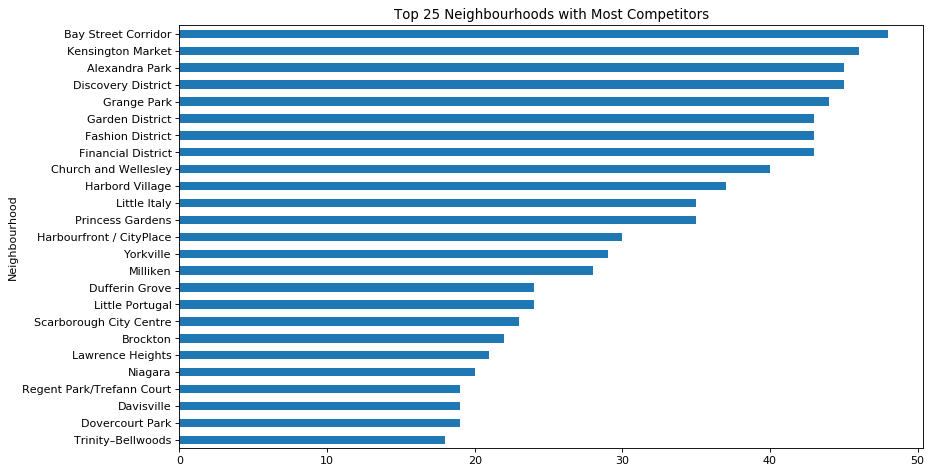

In [444]:
# plot bar chart of most competitors
plot_barh(['Competitors'], venue_df, 25)

#### From the top 25 neighbourhoods with most video game stores, we can see that there are most stores in Bay Street corridor, Kensington Market, Alexandra Park and Discovery District, but the average income of these neighbourhoods are not outstanding, therefore it may not be a good idea to open another store in these neighbourhoods.

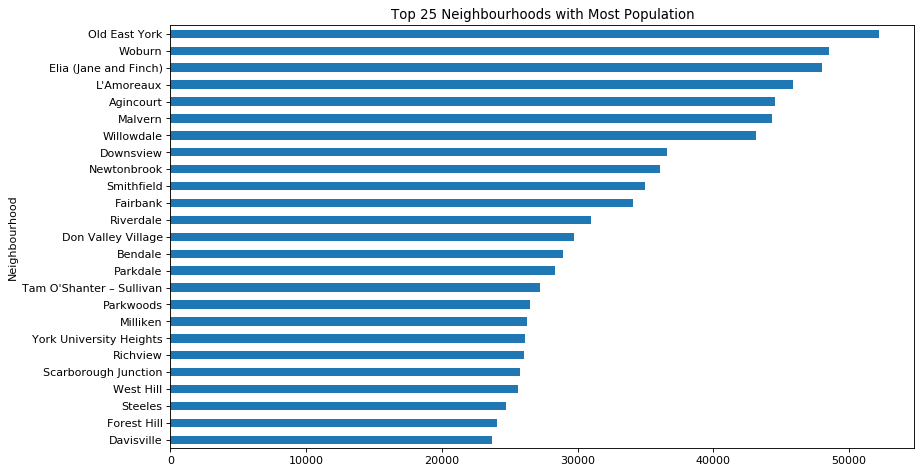

In [449]:
# plot bar chart of most population
plot_barh(['Population'], venue_df, 25)

#### From the bar chart of most population, we can see that Old East York is most densly populized. Here if we assume that the composition of video game players are evenly distributed among all Toronto city, then higher population could be an indicator of more potential customers, although we still need to check their consumption strength with other indicators such as income level, average age and land rents.  

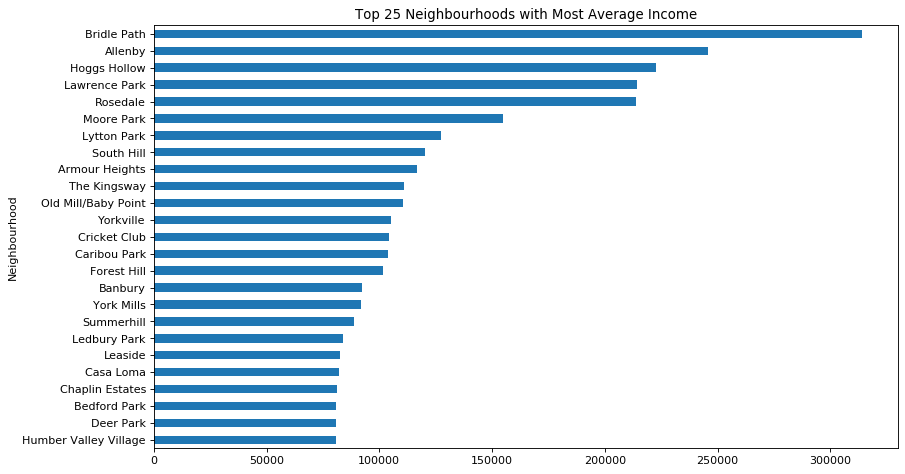

In [450]:
# plot bar chart of most average income
plot_barh(['Average Income'], venue_df, 25)

#### From the bar chart of most average income, it seems that people in Bridle Path, Allenby, and Hoggs Hollow are wat more better off than the rest Toronto city. This typically indicates that people in these neighbourhoods are more budget-free and they tends to spend more money for leasure purpose since they have loose budgets.

## 4. Conclusion


#### Data science can be used as effective tools to collect and get useful results to help make decision when it comes to opening a video game store in the Toronto City. Clusters of neighborhoods of similar music profile, or any profile, can be generated using high-quality venue location data. There is a preface on high-quality because analysis models are only as good as the input into them (garbage in, garbage out). Luckily, Foursquare offers a robust ‘Places API’ service that, although (as we have seen) not perfect (nothing is), can be leverages in similar studies and model-making.

#### This project is by no mens finished and could be expanded on in a number of different ways. Foursquare’s API could be further interrogated to retrieve and consider more videogame-related venues in Toronto City. New datasets of videogame-related venues can be acquired and potentially merged with what was retrieved from Foursquare. One may also use cluster algorithm to further analyze the data, for the purpose of getting more insights.

## 5. Acknowledgment

#### My project benefited from these works and tools:

#### https://towardsdatascience.com/tuning-in-to-nycs-music-neighborhoods-efb7ae77a4cd
#### https://developer.foursquare.com/docs/resources/categories
#### https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods